# Structural time series (STS) model with Poisson likelihood

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import lax

import sts_jax.structural_time_series.sts_model as sts

2022-12-06 12:59:55.123763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-06 12:59:55.123792: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-06 12:59:55.123794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


### Generate Synthetic Data

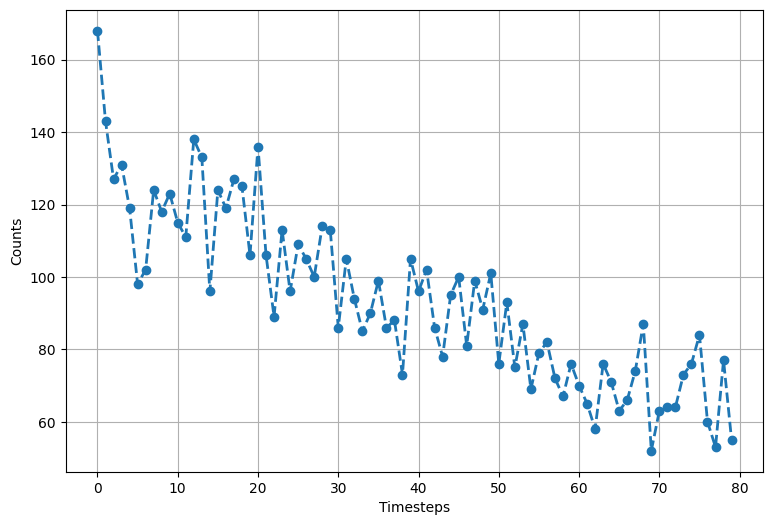

In [3]:
num_steps = 80
num_training_steps = 80
num_forecast_steps = 30

# Generate parameters of the local_linear_trend component
keys = jr.split(jr.PRNGKey(5), 5)
level_scale = 1.5
slope_scale = 0.01
initial_level = jr.normal(keys[0])
initial_slope = jr.normal(keys[1])
obs_noise_scale = 10

# Generate observed time series using the SSM representation.
F = jnp.array([[1, 1],
               [0, 1]])
H = jnp.array([[1, 0]])
Q = jnp.block([[level_scale, 0],
               [0, slope_scale]])
R = obs_noise_scale

def _step(current_state, key):
    key1, key2 = jr.split(key)
    log_obs_mean = H @ current_state
    next_state = F @ current_state + Q @ jr.normal(key2, shape=(2,))
    return next_state, log_obs_mean

initial_state = jnp.array([initial_level, initial_slope])
key_seq = jr.split(keys[2], num_steps)
_, log_time_series_mean = lax.scan(_step, initial_state, key_seq)
counts = jr.poisson(keys[2], jnp.exp(5+0.02*log_time_series_mean))

counts_training = counts[:num_training_steps]

# Plot the sequence of counts
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(counts, lw=2, linestyle='--', marker='o')
ax.set_ylabel("Counts")
ax.set_xlabel("Timesteps")
ax.grid()

### Plot function

In [4]:
def plot_forecast(model, param_samples, obs_time_series):
    # Forecast
    forecasts = model.forecast(param_samples, obs_time_series, num_forecast_steps)[1]
    forecasts = jnp.concatenate(forecasts, axis=0).squeeze()
    forecast_medians = jnp.median(forecasts, axis=0)
    forecast_quantiles = jnp.quantile(forecasts, jnp.array([0.1, 0.9]), axis=0)

    # Plot the forecast
    steps = jnp.arange(num_steps)
    forecast_steps = num_training_steps + jnp.arange(num_forecast_steps)
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(steps, counts, lw=2, linestyle='--', marker='o', label='Observation', color='C0')
    ax.plot(forecast_steps, forecast_medians, lw='2', linestyle='--', marker='o',
            color='C1', label='Forecast')
    ax.fill_between(forecast_steps, forecast_quantiles[0], forecast_quantiles[1],
                    color='C1', alpha=0.3)
    ax.set_ylabel("Counts")
    ax.set_xlabel("Steps")
    ax.legend()
    ax.grid()
    fig.suptitle("Forecast of time series with Poisson observation", fontsize=15)

## Implementation via CMGF

### Build the STS model

In [5]:
trend = sts.LocalLinearTrend()
model = sts.StructuralTimeSeries([trend],
                                 obs_distribution='Poisson',
                                 obs_time_series=counts_training,
                                 constant_offset=False)

### Model fitting

Running window adaptation


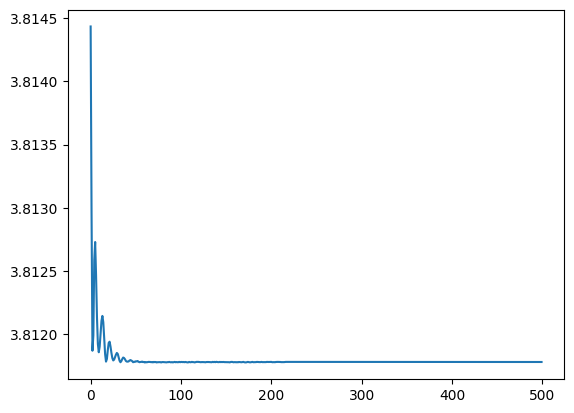

In [6]:
# Fit the model using HMC
opt_param, _losses = model.fit_mle(counts_training, num_steps=500)
param_samples, _log_probs = model.fit_hmc(
    num_samples=200, obs_time_series=counts_training, initial_params=opt_param)

plt.plot(_losses)

### Forecast

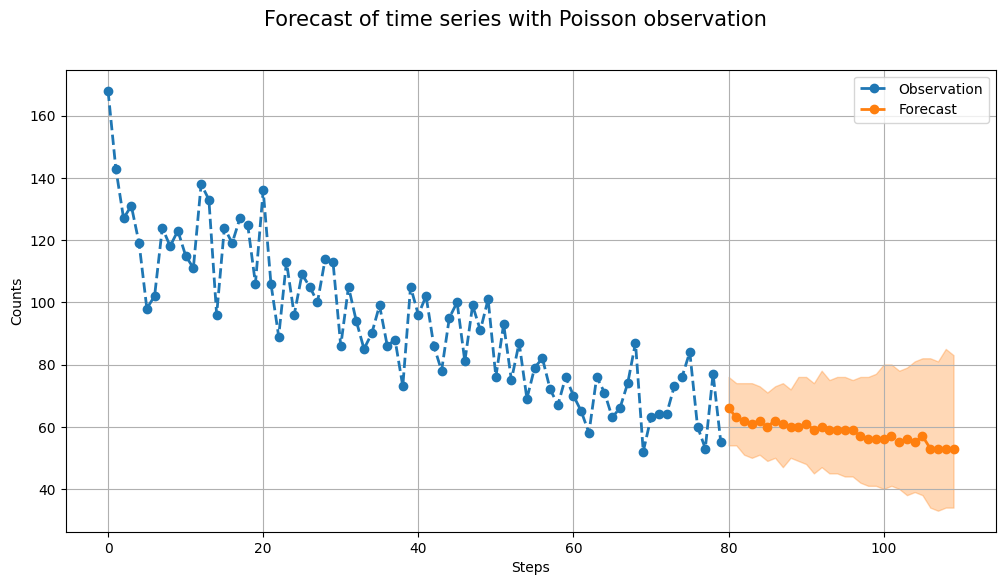

In [7]:
plot_forecast(model, param_samples, counts_training)